In [33]:
#Librerias necesarias para el proyecto

import kagglehub
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import os
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

In [11]:
# Definimos la ruta completa hasta donde están las 8 carpetas de cáncer
path = r'C:\Users\inter\.cache\kagglehub\datasets\obulisainaren\multi-cancer\versions\3\Multi Cancer\Multi Cancer'

In [12]:
# Configuración del Generador
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Carga de Entrenamiento
train_generator = datagen.flow_from_directory(
    path, 
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Carga de Validación
val_generator = datagen.flow_from_directory(
    path, 
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Variables de clase
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)

print(f"\nÉxito: Se han detectado {num_classes} clases.")
print(f"Nombres de las clases: {class_names}")

Found 104002 images belonging to 8 classes.
Found 26000 images belonging to 8 classes.

Éxito: Se han detectado 8 clases.
Nombres de las clases: ['ALL', 'Brain Cancer', 'Breast Cancer', 'Cervical Cancer', 'Kidney Cancer', 'Lung and Colon Cancer', 'Lymphoma', 'Oral Cancer']


In [13]:
model_cnn = Sequential([
    # Capa Convolucional 1:
    # Ajustamos input_shape a (224, 224, 3) para que coincida con nuestro generator
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)), 
    
    # Capa Convolucional 2:
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)), 
    
    # Bloque de Clasificación
    Flatten(),
    
    # Capa densa de interpretación
    Dense(64, activation='relu'),
    
    # Capa de salida: num_classes se ajustará automáticamente a las carpetas de Kaggle
    Dense(num_classes, activation='softmax')
])

model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │    12,845,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,865,032 (49.08 MB)

 Trainable params: 12,865,032 (49.08 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# early stopping para evitar sobreajuste
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True
)

In [19]:
model_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

print("\n--- Entrenando la CNN con el Dataset de Cáncer ---")

history_cnn = model_cnn.fit(
    train_generator,
    epochs=5,                
    validation_data=val_generator,
    callbacks=[early_stop]
)


--- Entrenando la CNN con el Dataset de Cáncer ---
Epoch 1/5
3251/3251 ━━━━━━━━━━━━━━━━━━━━ 1841s 565ms/step - accuracy: 0.9690 - loss: 0.0994 - val_accuracy: 0.9866 - val_loss: 0.0466
Epoch 2/5
3251/3251 ━━━━━━━━━━━━━━━━━━━━ 1607s 494ms/step - accuracy: 0.9895 - loss: 0.0347 - val_accuracy: 0.9661 - val_loss: 0.1150
Epoch 3/5
3251/3251 ━━━━━━━━━━━━━━━━━━━━ 1672s 514ms/step - accuracy: 0.9925 - loss: 0.0265 - val_accuracy: 0.9423 - val_loss: 0.2026
Epoch 4/5
3251/3251 ━━━━━━━━━━━━━━━━━━━━ 1683s 518ms/step - accuracy: 0.9943 - loss: 0.0215 - val_accuracy: 0.9738 - val_loss: 0.0785


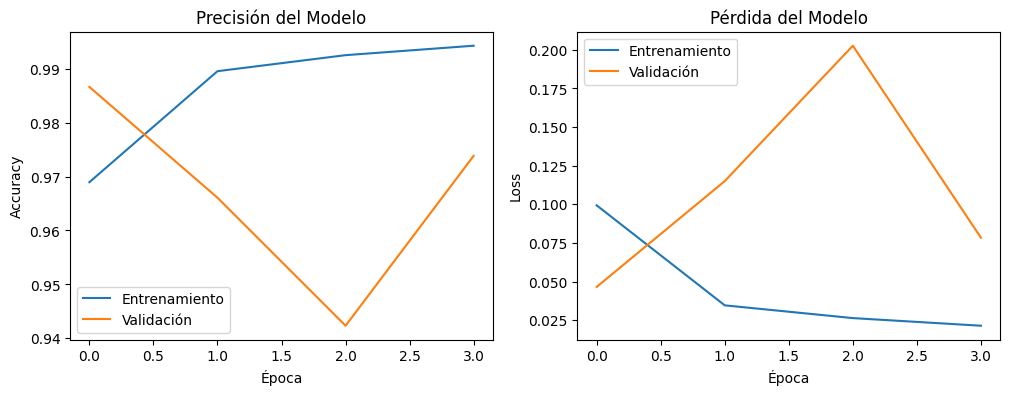

In [22]:
# 1. Graficar la evolución del entrenamiento
def graficar_rendimiento(history):
    plt.figure(figsize=(12, 4))
    
    # Gráfica de Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title('Precisión del Modelo')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()

    # Gráfica de Pérdida (Loss)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Pérdida del Modelo')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

graficar_rendimiento(history_cnn)

Found 26000 images belonging to 8 classes.
Evaluando modelo...
813/813 ━━━━━━━━━━━━━━━━━━━━ 121s 148ms/step

--- REPORTE DE CLASIFICACIÓN ---
                       precision    recall  f1-score   support

                  ALL       0.99      1.00      0.99      4000
         Brain Cancer       1.00      1.00      1.00      3000
        Breast Cancer       0.96      0.94      0.95      2000
      Cervical Cancer       0.99      0.99      0.99      5000
        Kidney Cancer       1.00      1.00      1.00      2000
Lung and Colon Cancer       0.98      0.98      0.98      5000
             Lymphoma       1.00      1.00      1.00      3000
          Oral Cancer       0.94      0.95      0.95      2000

             accuracy                           0.99     26000
            macro avg       0.98      0.98      0.98     26000
         weighted avg       0.99      0.99      0.99     26000



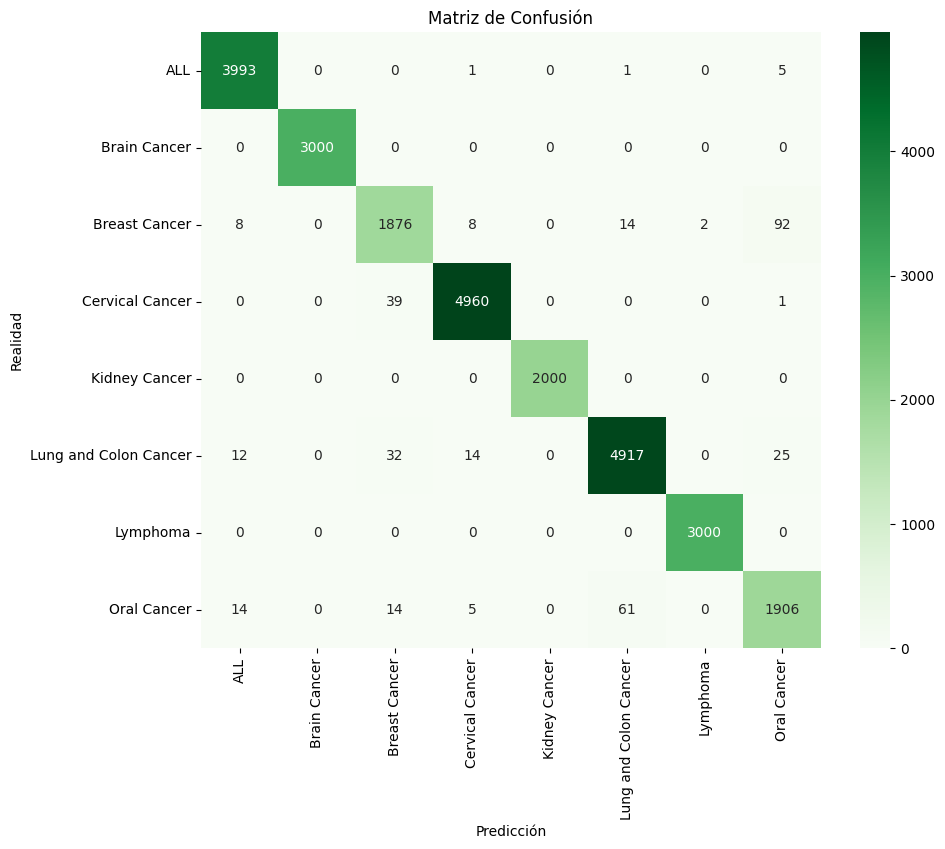

In [30]:
# 1. Crear un generador de prueba
test_generator = datagen.flow_from_directory(
    path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# 2. Generar las predicciones
print("Evaluando modelo...")
y_pred = model_cnn.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes # Ahora sí coinciden los índices

print("\n--- REPORTE DE CLASIFICACIÓN ---")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# 3. Matriz de Confusión Visual
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión')
plt.ylabel('Realidad')
plt.xlabel('Predicción')
plt.show()

In [ ]:
#Exportar el modelo entrenado, para no volver a ejecutarlo
model_cnn.save('..\\Resultados\\modelo_cancer_8clases.h5')

### **Probar modelo con una imagen que nunca ha visto**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


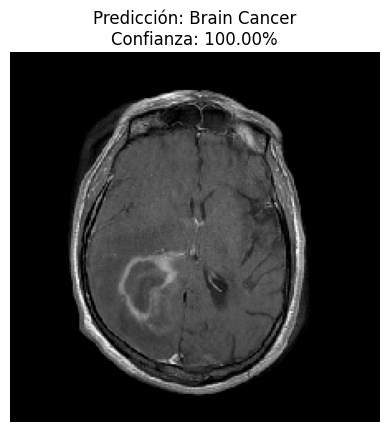

El modelo está un 100.00% seguro de que es: Brain Cancer


In [ ]:
def probar_imagen_nueva(ruta_foto, modelo, class_names):
    # 1. Cargar la imagen ajustándola al tamaño que usa tu red (224x224)
    img = image.load_img(ruta_foto, target_size=(224, 224))
    
    # 2. Convertirla a un arreglo de números
    img_array = image.img_to_array(img)
    
    # 3. Normalizar
    img_array = img_array / 255.0
    
    # 4. Añadir una dimensión extra (batch dimension) 
    # El modelo espera (1, 224, 224, 3) en lugar de (224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0)
    
    # 5. Realizar la predicción
    prediccion = modelo.predict(img_array)
    indice_clase = np.argmax(prediccion, axis=1)[0]
    probabilidad = np.max(prediccion) * 100
    
    # 6. Mostrar el resultado
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicción: {class_names[indice_clase]}\nConfianza: {probabilidad:.2f}%")
    plt.show()
    
    print(f"El modelo está un {probabilidad:.2f}% seguro de que es: {class_names[indice_clase]}")

# --- EJECUCIÓN ---

ruta_de_mi_foto = r'C:\U.Externado\ML-RN\TallerSSD\Documentos\image_2.jpg'
probar_imagen_nueva(ruta_de_mi_foto, model_cnn, class_names)

##### Dirección URL de la imagen nueva para el modelo

https://prod-images-static.radiopaedia.org/images/20999/399c6a661fb9c09e23f4f14fb18120.jpg